In [1]:
import pbjam as pb
from pbjam.jar import session
import matplotlib.pyplot as plt
import numpy as np
import lightkurve as lk 
import sys
import astropy.units as units
import pandas as pd
import lightkurve as lk
import importlib


In [2]:
kic = '4448777'
numax = [220.0, 3.0]
dnu = [16.97, 0.05]
teff = [4750, 100]
bp_rp = [1.34, 0.1]

In [3]:
lc = lk.search_lightcurvefile(kic, quarter=1).download().PDCSAP_FLUX.normalize().flatten(window_length=401)
for q in range(2,17):
    lc = lc.append(lk.search_lightcurvefile(kic, quarter=q).download().PDCSAP_FLUX.normalize().flatten(window_length=401))


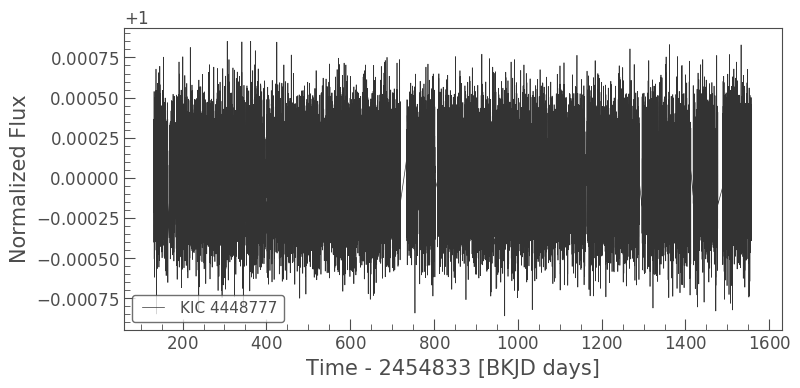

In [4]:
lc = lc.remove_outliers(4)
lc.plot()

In [5]:
pg = lc.to_periodogram(normalization='psd', minimum_frequency=150.0).flatten()

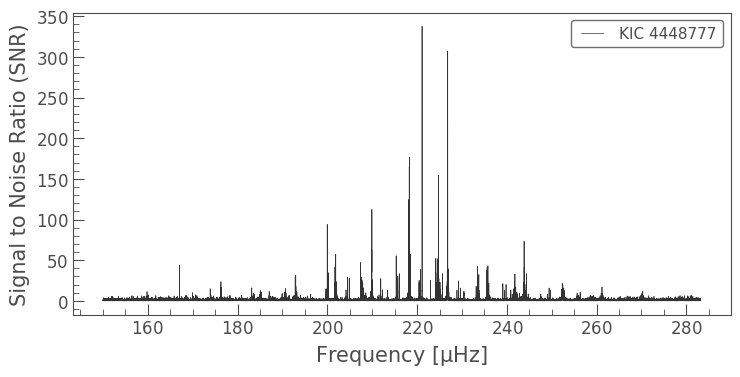

In [6]:
pg.plot()

In [7]:
ep = pb.epsilon()
result = ep(dnu=dnu, numax=numax, teff=teff, bp_rp=bp_rp, bw_fac=1.0)

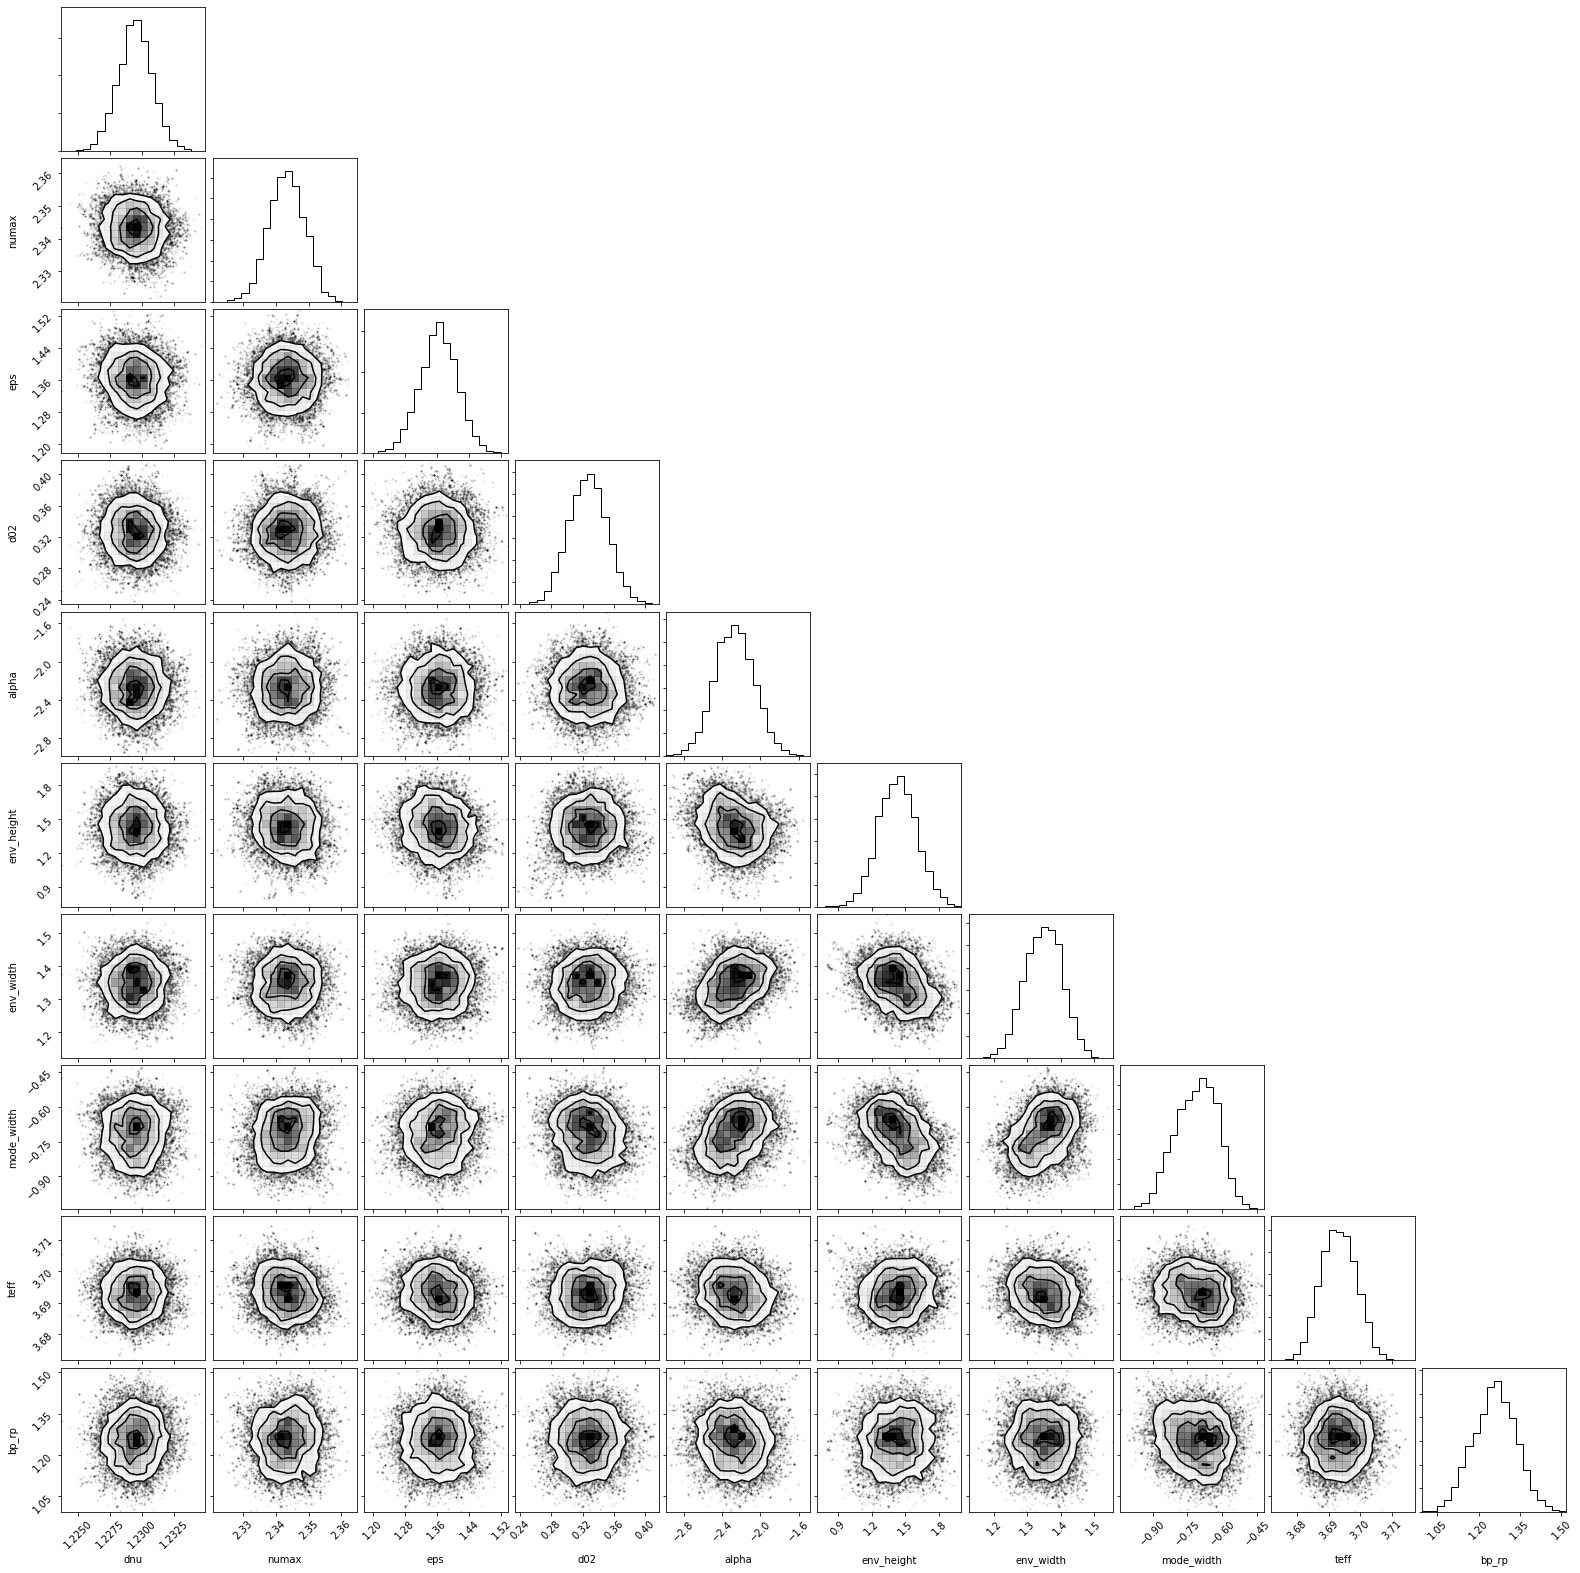

In [8]:
import corner
corner.corner(ep.samples, labels=ep.cols);

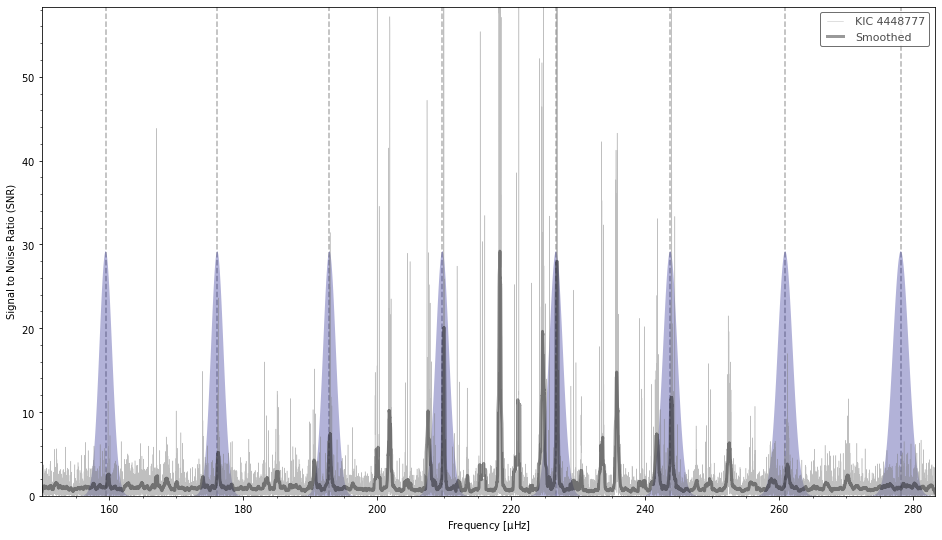

In [10]:
ep.plot(pg)

In [11]:
importlib.reload(pb.asy_peakbag)
asy = pb.asy_peakbag.asymptotic_fit(pg.frequency.value, pg.power.value, 
                                    ep.samples, 
                                    teff, bp_rp, 
                                    nthreads=4, norders=7,
                                    store_chains=True)

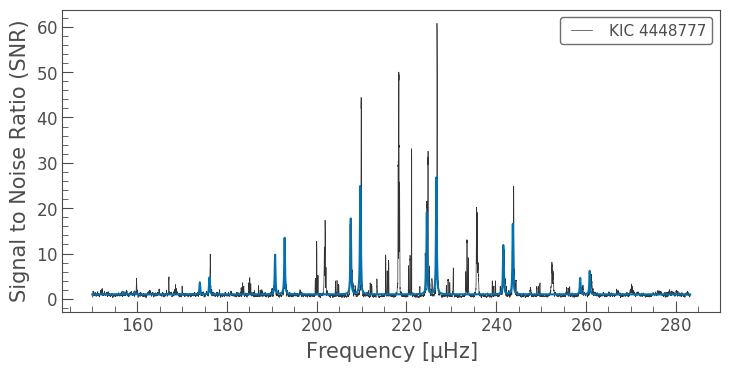

In [12]:
ax = pg.smooth().plot()
ax.plot(asy.model.f, asy.model(asy.start))

In [13]:
asy_result = asy.run(burnin=1000, niter=1000)

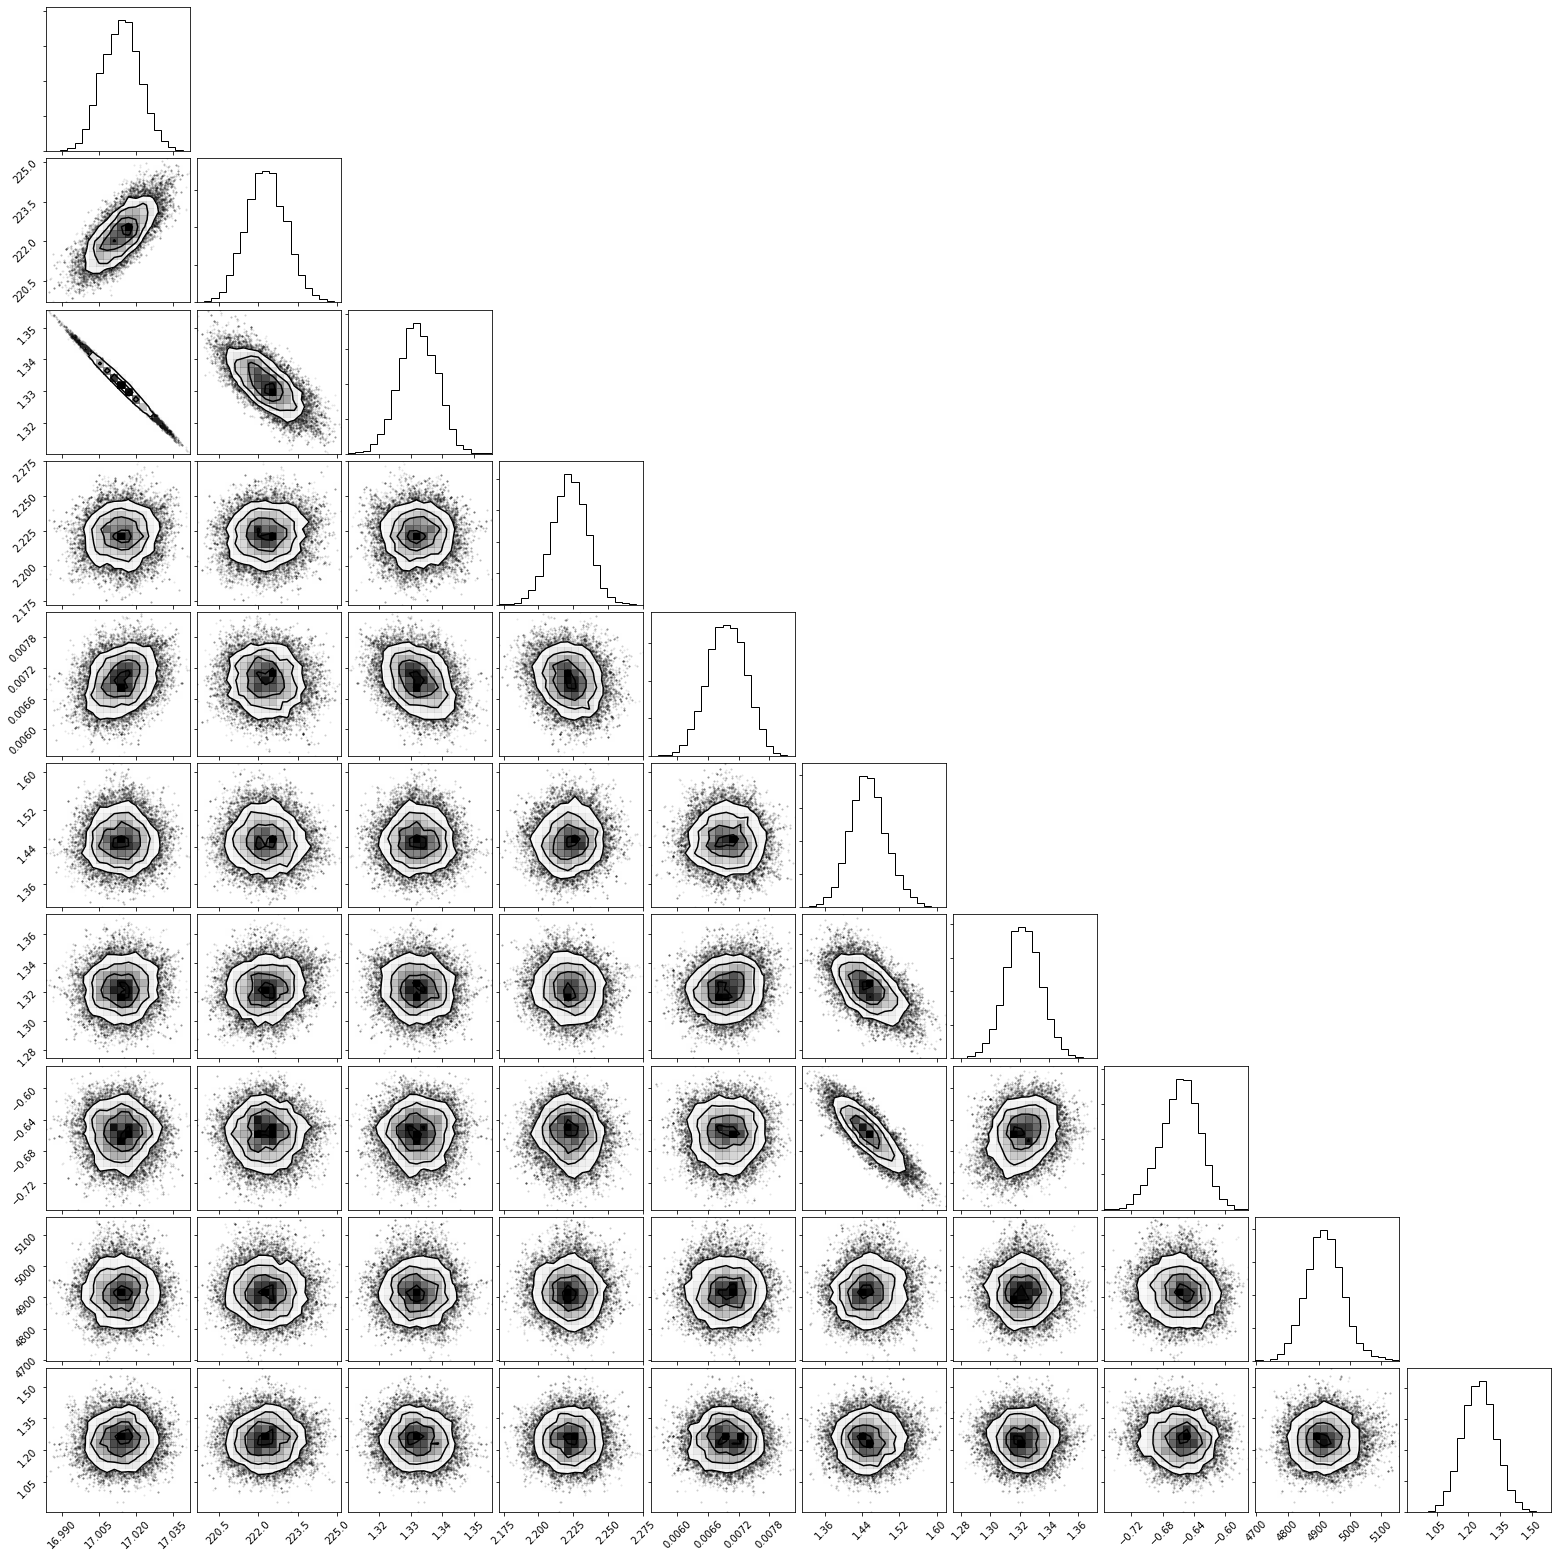

In [14]:
corner.corner(asy.flatchain);

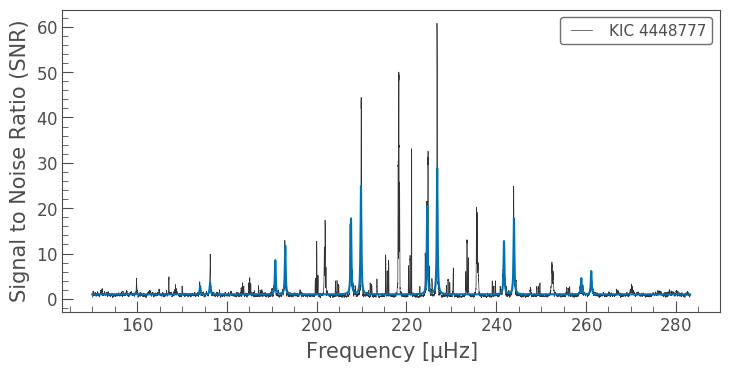

In [15]:
ax = pg.smooth().plot()
ax.plot(asy.model.f, asy.model(asy.flatchain.mean(axis=0)))

In [16]:
asy_result['summary']

,dnu,numax,eps,d02,alpha,env_height,env_width,mode_width,teff,bp_rp
mle,17.014630,222.100548,1.331695,2.219324,0.007045,1.446568,1.320601,-0.652529,4948.662568,1.269169
mean,17.013958,222.300577,1.332280,2.222319,0.006962,1.453618,1.322460,-0.657559,4918.631779,1.251196
std,0.007626,0.757752,0.005909,0.012674,0.000376,0.040029,0.012291,0.024939,59.473185,0.079235
skew,-0.009783,0.094522,-0.002376,-0.046853,-0.075945,0.210032,0.029294,-0.188309,0.232536,0.093436
2nd,16.998988,220.837104,1.320390,2.196402,0.006203,1.376718,1.297598,-0.710400,4804.346715,1.095139
16th,17.006155,221.542999,1.326404,2.209728,0.006584,1.414531,1.310560,-0.682640,4860.115574,1.171500
50th,17.014105,222.290717,1.332200,2.222459,0.006962,1.451933,1.322273,-0.656419,4917.169408,1.250732
84th,17.021528,223.058885,1.338310,2.234845,0.007341,1.493662,1.334515,-0.633073,4975.427248,1.330750
97th,17.029296,223.870236,1.343891,2.247803,0.007681,1.538726,1.347480,-0.609937,5046.823585,1.413243
MAD,0.007713,0.759012,0.006020,0.012528,0.000387,0.038703,0.012036,0.024481,57.552025,0.079457


In [17]:
from pbjam import peakbag 
import pymc3 as pm
import importlib
import pbjam

In [21]:
pbag = pbjam.peakbag(pg.frequency.value, pg.power.value, asy_result)

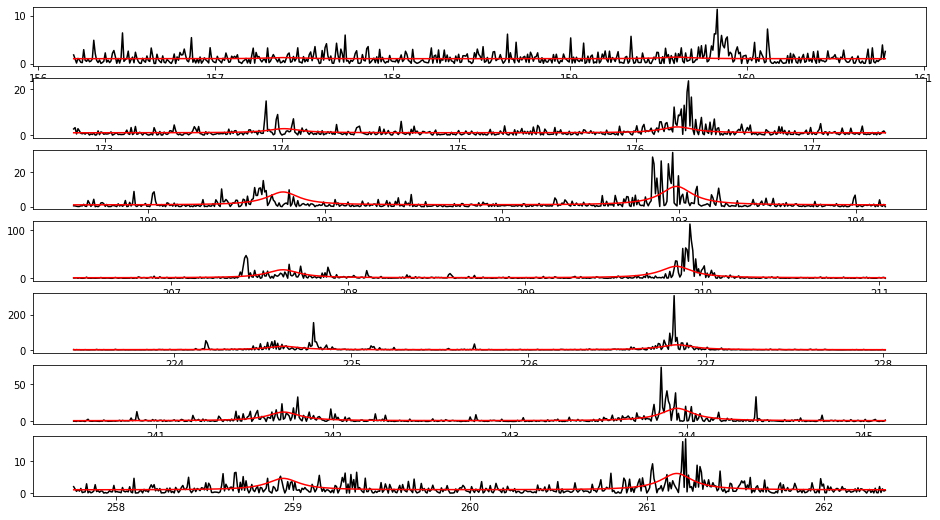

In [22]:
pbag.plot_start_model()

In [23]:
pbag.sample(model_type='simple', cores=4, tune=1500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [back, height2, height0, width2, width0, l2, l0]
Sampling 4 chains: 100%|██████████| 8000/8000 [06:22<00:00,  8.51draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6789286031962135, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


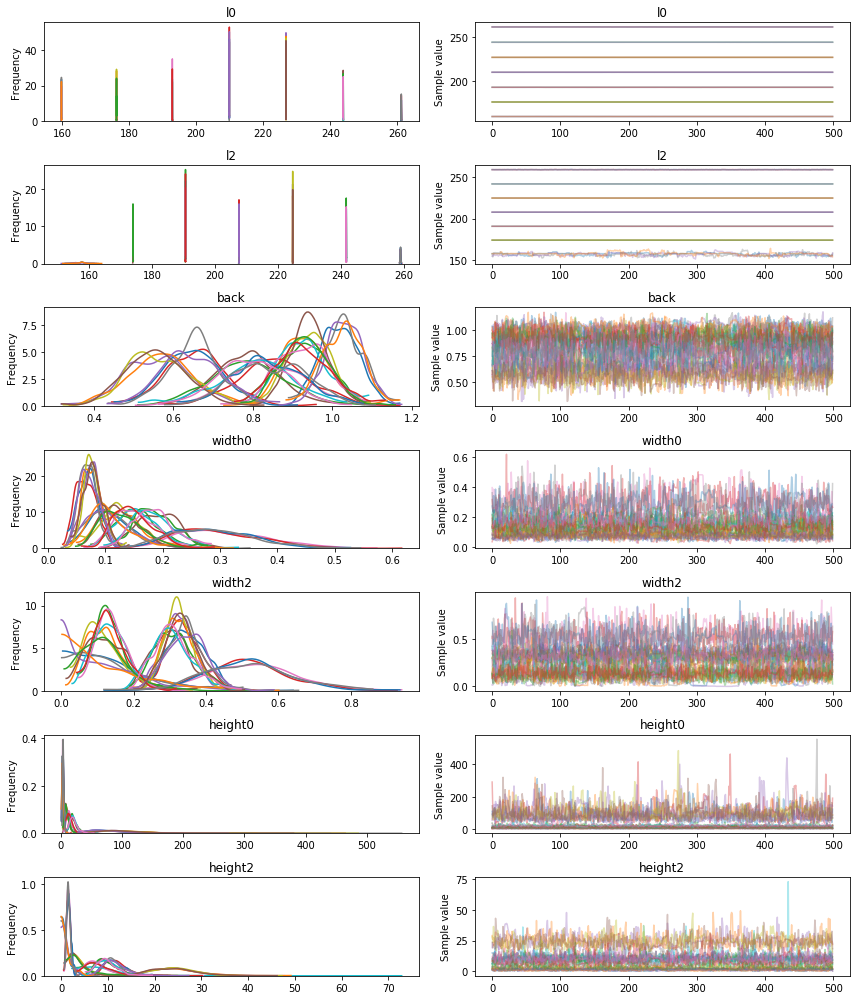

In [24]:
pbag.traceplot()

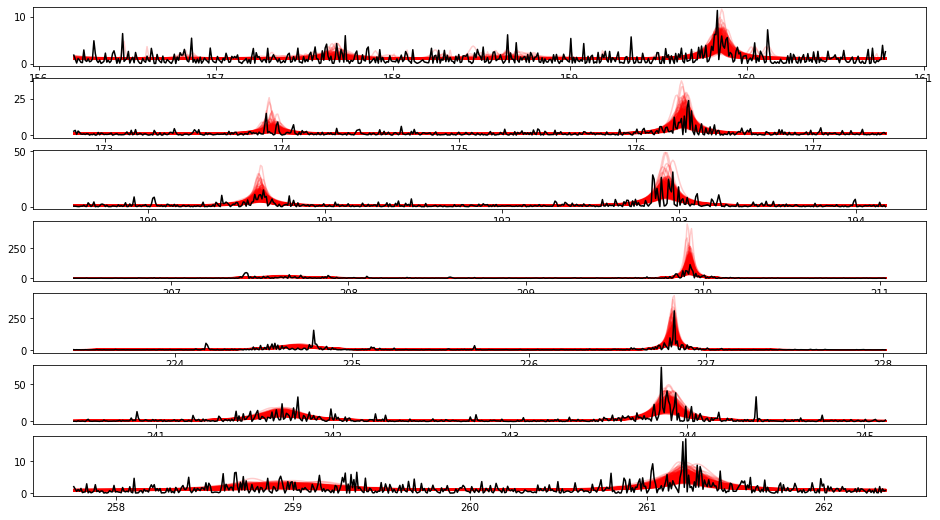

In [25]:
pbag.plot_fit(thin=1)

In [26]:
pm.summary(pbag.samples)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
l0__0,159.846559,0.017682,0.000537,159.812047,159.881843,969.382926,1.001829
l0__1,176.269791,0.015803,0.000577,176.240360,176.301734,653.354793,1.002531
l0__2,192.924153,0.014962,0.000496,192.896205,192.952962,930.188497,1.000765
l0__3,209.925125,0.008222,0.000214,209.908552,209.940054,1451.121401,1.001496
l0__4,226.814508,0.008392,0.000214,226.799345,226.832623,1538.513068,0.999563
l0__5,243.889371,0.015534,0.000513,243.860864,243.922004,997.846042,1.003629
l0__6,261.213950,0.030517,0.000862,261.149529,261.271831,1212.368747,0.999397
l2__0,157.035954,1.726413,0.114654,153.531195,160.370255,160.544610,1.018056
l2__1,173.947550,0.026021,0.000983,173.899609,174.002264,624.173766,1.000663
l2__2,190.628595,0.016779,0.000606,190.597165,190.662278,567.352424,1.007655
